In [13]:
import numpy as np
import pandas as pd
import nltk
import string
import re
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes
from sklearn.metrics import roc_auc_score
from urllib.request import urlopen
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import requests
from bs4 import BeautifulSoup as soup
from matplotlib import pyplot as plt

In [14]:
# importing datasets (4 Amazon review datasets)

appliance_df = pd.read_csv('amazon_reviews_us_Major_Appliances_v1_00.tsv', sep='\t', error_bad_lines=False)
apparel_df = pd.read_csv('amazon_reviews_us_Apparel_v1_00.tsv', sep='\t', error_bad_lines=False)
sports_df = pd.read_csv('amazon_reviews_us_Sports_v1_00.tsv', sep='\t', error_bad_lines=False,
                       dtype={'helpful_votes': 'float64',
                             'star_rating': 'object',
                             'total_votes': 'float64'})
electronics_df = pd.read_csv('amazon_reviews_us_Electronics_v1_00.tsv', sep='\t', error_bad_lines=False)

b'Skipping line 5583: expected 15 fields, saw 22\nSkipping line 22814: expected 15 fields, saw 22\nSkipping line 22883: expected 15 fields, saw 22\nSkipping line 29872: expected 15 fields, saw 22\nSkipping line 37242: expected 15 fields, saw 22\nSkipping line 59693: expected 15 fields, saw 22\n'
b'Skipping line 49396: expected 15 fields, saw 22\nSkipping line 57008: expected 15 fields, saw 22\n'
b'Skipping line 82075: expected 15 fields, saw 22\nSkipping line 104435: expected 15 fields, saw 22\nSkipping line 109766: expected 15 fields, saw 22\nSkipping line 124024: expected 15 fields, saw 22\nSkipping line 129914: expected 15 fields, saw 22\nSkipping line 130172: expected 15 fields, saw 22\n'
b'Skipping line 161515: expected 15 fields, saw 22\n'
b'Skipping line 230464: expected 15 fields, saw 22\n'
b'Skipping line 292640: expected 15 fields, saw 22\nSkipping line 293681: expected 15 fields, saw 22\nSkipping line 316511: expected 15 fields, saw 22\nSkipping line 317239: expected 15 fiel

b'Skipping line 945450: expected 15 fields, saw 22\nSkipping line 949785: expected 15 fields, saw 22\nSkipping line 958534: expected 15 fields, saw 22\n'
b'Skipping line 1006147: expected 15 fields, saw 22\nSkipping line 1020875: expected 15 fields, saw 22\nSkipping line 1027474: expected 15 fields, saw 22\nSkipping line 1033688: expected 15 fields, saw 22\n'
b'Skipping line 1056719: expected 15 fields, saw 22\nSkipping line 1067438: expected 15 fields, saw 22\nSkipping line 1079099: expected 15 fields, saw 22\nSkipping line 1085814: expected 15 fields, saw 22\nSkipping line 1112836: expected 15 fields, saw 22\n'
b'Skipping line 1124957: expected 15 fields, saw 22\nSkipping line 1138765: expected 15 fields, saw 22\nSkipping line 1148270: expected 15 fields, saw 22\nSkipping line 1160930: expected 15 fields, saw 22\nSkipping line 1162655: expected 15 fields, saw 22\n'
b'Skipping line 1192443: expected 15 fields, saw 22\nSkipping line 1229660: expected 15 fields, saw 22\nSkipping line 12

b'Skipping line 714935: expected 15 fields, saw 22\n'
b'Skipping line 749608: expected 15 fields, saw 22\nSkipping line 753868: expected 15 fields, saw 22\nSkipping line 762504: expected 15 fields, saw 22\nSkipping line 771706: expected 15 fields, saw 22\nSkipping line 773376: expected 15 fields, saw 22\n'
b'Skipping line 792407: expected 15 fields, saw 22\nSkipping line 793933: expected 15 fields, saw 22\nSkipping line 813269: expected 15 fields, saw 22\nSkipping line 835491: expected 15 fields, saw 22\nSkipping line 841176: expected 15 fields, saw 22\nSkipping line 844604: expected 15 fields, saw 22\n'
b'Skipping line 857952: expected 15 fields, saw 22\nSkipping line 859568: expected 15 fields, saw 22\nSkipping line 860789: expected 15 fields, saw 22\nSkipping line 863093: expected 15 fields, saw 22\nSkipping line 881608: expected 15 fields, saw 22\nSkipping line 891157: expected 15 fields, saw 22\nSkipping line 893799: expected 15 fields, saw 22\nSkipping line 906438: expected 15 fi

In [15]:
# data processing
appliance_df = appliance_df[['star_rating', 'review_body']]
appliance_df = appliance_df.dropna()
apparel_df = apparel_df[['star_rating', 'review_body']]
apparel_df = apparel_df.dropna()
sports_df = sports_df[['star_rating', 'review_body']]
sports_df = sports_df.dropna()
electronics_df = electronics_df[['star_rating', 'review_body']]
electronics_df = electronics_df.dropna()

appliance_df = appliance_df.astype({'star_rating': 'int32', 'review_body': 'str'})
apparel_df = apparel_df.astype({'star_rating': 'int32', 'review_body': 'str'})
sports_df = sports_df.astype({'star_rating': 'int32', 'review_body': 'str'})
electronics_df = electronics_df.astype({'star_rating': 'int32', 'review_body': 'str'})

# 4 or 5 star ratings are positive
pos_appliance_df = appliance_df[(appliance_df['star_rating'] == 4) | (appliance_df['star_rating'] == 5)][:25000]
pos_apparel_df = apparel_df[(apparel_df['star_rating'] == 4) | (apparel_df['star_rating'] == 5)][:25000]
pos_sports_df = sports_df[(sports_df['star_rating'] == 4) | (sports_df['star_rating'] == 5)][:25000]
pos_electronics_df = electronics_df[(electronics_df['star_rating'] == 4) | (electronics_df['star_rating'] == 5)][:25000]

# 1 and 2 star ratings are negative
neg_appliance_df = appliance_df[(appliance_df['star_rating'] == 1) | (appliance_df['star_rating'] == 2)][:25000]
neg_apparel_df = apparel_df[(apparel_df['star_rating'] == 1) | (apparel_df['star_rating'] == 2)][:25000]
neg_sports_df = sports_df[(sports_df['star_rating'] == 1) | (sports_df['star_rating'] == 2)][:25000]
neg_electronics_df = electronics_df[(electronics_df['star_rating'] == 1) | (electronics_df['star_rating'] == 2)][:25000]

# combining into one df (need to grab 50)

In [16]:
# combining data frame
combined_df = pd.concat([pos_appliance_df, pos_apparel_df, pos_sports_df, pos_electronics_df,
                        neg_appliance_df, neg_apparel_df, neg_sports_df, neg_electronics_df], axis=0)

In [17]:
combined_df.shape #100k positive and 100k negative

(200000, 2)

In [18]:
# creating sentiment column
def applySentiment(rating):
    if rating == 4 or rating == 5:
        return 1
    elif rating == 1 or rating == 2:
        return 0
    
combined_df['sentiment'] = combined_df['star_rating'].apply(lambda x: applySentiment(x))

In [19]:
# cleaning
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = nltk.stem.WordNetLemmatizer()

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = " ".join([lemmatizer.lemmatize(word) for word in tokens if word not in stopwords])
    return text

# use for tfidf (tokens are separated in a list)
def clean_text2(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords]
    return text

combined_df['cleaned_reviews'] = combined_df['review_body'].apply(lambda x: clean_text(x))
combined_df.head()

,star_rating,review_body,sentiment,cleaned_reviews
0,5,What a great stove. What a wonderful replacem...,1,great stove wonderful replacement sort antique...
1,5,worked great,1,worked great
2,5,Part exactly what I needed. Saved by purchasi...,1,part exactly needed saved purchasing
3,5,Love my refrigerator! ! Keeps everything cold...,1,love refrigerator keep everything coldwill rec...
4,5,No more running to the store for ice! Works p...,1,running store ice work perfectly


In [28]:
# download
combined_df.to_csv('reviews.csv')

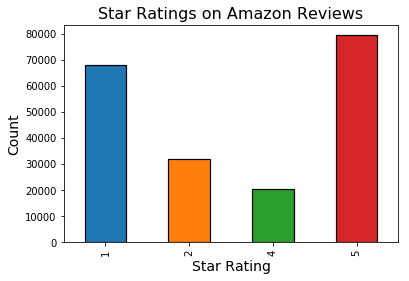

In [8]:
# EDA / VIZ

# Star Rating Distribution
star_rating_dist = pd.value_counts(combined_df['star_rating'].values, sort=False)
# combined_df['star_rating'].hist(bins=5, color='royalblue', edgecolor='black', linewidth=1.4)
# plt.xticks(np.arange(1,6,1))
star_rating_dist.plot.bar(edgecolor='black', linewidth=1.2)
plt.title('Star Ratings on Amazon Reviews', size=16)
plt.xlabel('Star Rating', size=14)
plt.ylabel('Count', size=14)
plt.show()

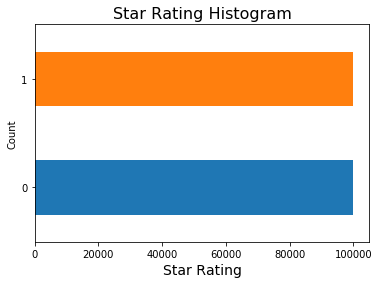

In [9]:
# Sentiment Distribution
sentiment_dist = pd.value_counts(combined_df['sentiment'].values, sort=False)
sentiment_dist.plot.barh()
plt.title('Star Rating Histogram', size=16)
plt.xlabel('Star Rating', size=14)
plt.ylabel('Count')
plt.show()

In [92]:
# # picture of vectorizer (will use sample)
# dontwant = ["", 110, 220, "3rd", 4000]
# review_sample = combined_df.iloc[:20]
# vectorizer = TfidfVectorizer(analyzer=clean_text2)
# y = review_sample['sentiment']
# X = vectorizer.fit_transform(review_sample['review_body'])
# tf_idf_df = pd.DataFrame(X.toarray())
# tf_idf_df.columns = vectorizer.get_feature_names()
# tf_idf_df[tf_idf_df.columns.all(dontwant)]
# tf_idf_df

In [60]:
# bigrams
vectorizer = CountVectorizer(ngram_range=(1,2))

In [51]:
# TFIDF Vectorizer
# vectorizer = TfidfVectorizer(use_idf=True, lowercase=True, strip_accents='ascii', stop_words=stopwords)
# vectorizer = TfidfVectorizer(analyzer=clean_text2)

In [61]:
# dependent variable (0 or 1 for bad or good review)
y = combined_df['sentiment']

In [62]:
# convert reviews to features
X = vectorizer.fit_transform(combined_df['cleaned_reviews'])

In [63]:
print(y.shape)
print(X.shape)

(200000,)
(200000, 1912518)


In [24]:
import random
# getting features for unigram + bigrams

grams = vectorizer.get_feature_names()
for i in range(10):
    print(random.choice(grams))

installed outdoors
electronics designif
wrist toddler
9130
music hang
samsung dmt400rhb
really dim
suprised purchase
longer effectbr
wasting blank


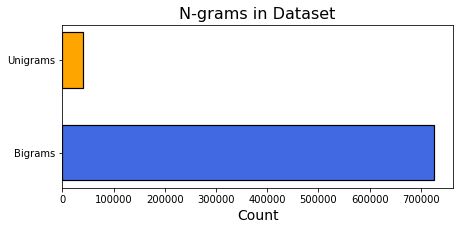

In [25]:
# update later
plt.subplots(figsize=(7,3))
plt.barh(['Bigrams', 'Unigrams'], [726370, 41208], height=0.6, color=['royalblue', 'orange'], edgecolor='black',
        linewidth=1.2)
plt.title('N-grams in Dataset', size=16)
plt.xlabel('Count', size=14)
plt.show()

In [64]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
C_list = [0.01, 0.05, 0.25, 0.5, 1]
accuracy_rates = []

for c in C_list:
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_test, lr.predict(X_test))))
    accuracy_rates.append(accuracy_score(y_test, lr.predict(X_test)))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.8614
Accuracy for C=0.05: 0.881975
Accuracy for C=0.25: 0.8942
Accuracy for C=0.5: 0.897875
Accuracy for C=1: 0.89985


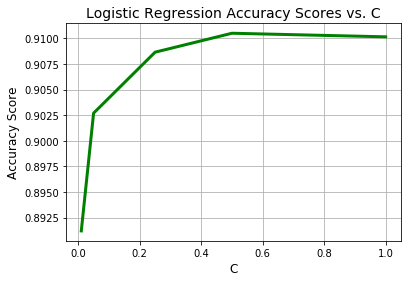

In [41]:
plt.plot(C_list, accuracy_rates, color='green', linewidth=3)
plt.grid(b=True)
plt.title("Logistic Regression Accuracy Scores vs. C", size=14)
plt.xlabel("C", size=12)
plt.ylabel("Accuracy Score", size=12)
plt.show()

In [65]:
# training Naive Bayes Classifier
classifier = LogisticRegression(C=0.5)
# classifier = naive_bayes.MultinomialNB()
classifier.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [66]:
# testing accuracy with test set
roc_auc_score(y_test, classifier.predict_proba(X_test)[:,1])

0.9635906592898557

In [67]:
reviews_array = np.array(["great post thank previous comment stated get 1 reward back using rush shipping"])
reviews_vector = vectorizer.transform(reviews_array)
print(classifier.predict(reviews_vector))

[1]


In [74]:
# evaluation
feature_to_coef = {
    word: coef for word, coef in zip(
        vectorizer.get_feature_names(), classifier.coef_[0]
    )
}

for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[10:20]:
    print(best_positive)
    
print()

for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:10]:
    print(best_negative)

('wont disappointed', 2.328084947679044)
('outstanding', 2.3241511259274166)
('excelent', 2.2767335057812574)
('thank', 2.0888322024182235)
('nice', 2.0475525797926135)
('beautiful', 2.0392904105388174)
('exactly', 2.0205301086553105)
('comfy', 2.0198080775328298)
('well worth', 2.016797796603467)
('best', 2.012738901121185)

('disappointing', -2.958663645591936)
('worst', -2.860739724161931)
('horrible', -2.814715918065265)
('disappointed', -2.8124488985133587)
('doesnt work', -2.6955793100232692)
('broke', -2.669486102369575)
('poor', -2.657336590601256)
('returned', -2.6352923478010677)
('junk', -2.619068995999011)
('terrible', -2.6186679567198845)


In [69]:
# evaluation
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[18216,  1791],
       [ 1789, 18204]])

In [70]:
# model evaluation metrics (precision, recall, F1)
print("precision: {}".format(precision_score(y_test, y_pred)))
print("recall: {}".format(recall_score(y_test, y_pred)))
print("f1 score: {}".format(f1_score(y_test, y_pred)))

precision: 0.9104276069017254
recall: 0.9105186815385385
f1 score: 0.9104731419425828


In [26]:
# NOW FOR SLICKDEALS DATA

sdeals_page = "http://slickdeals.net"
url = urlopen(sdeals_page)
url_read = url.read()
url.close()

page_soup = soup(url_read, "html.parser")

grid_deals = page_soup.find("ul", {"class":"dealTiles gridDeals",
                                "data-role":"deal-tiles"})
item_container = grid_deals.find_all('li')

def fix_text(text):
    text = re.sub(r'&lpar', '(', text)
    text = re.sub(r'&rpar', ')', text)
    text = re.sub(r'&plus', '+', text)
    text = re.sub(r'&apos', '\'', text)
    text = re.sub(r'&colon', ':', text)
    text = re.sub(r'&sol', '/', text)
    text = re.sub(r'&dollar', '$', text)
    text = re.sub(r'&comma', ',', text)
    text = re.sub(r'&period', '.', text)
    text = re.sub(r'&percnt', '%', text)
    text = re.sub(r'&excl', '?', text)
    text = re.sub(r'&num', '#', text)
    return text


df = pd.DataFrame(columns=['Item', 'Price', 'Old Price', 'Url', 'Positive Feedback Rating'])
counter = 0

test_counter = 0

# store content regex
content_re = re.compile(r'\w+')
space_re = re.compile(r'\s{2,}')

for item in item_container:
    try:
        # will add instances to df
        to_add = []
        
        # getting the item's title
        item_title = item.find("a", {"class":"itemTitle"}).text.strip()
        # cleaning the &___; - this may be added onto
        item_title = fix_text(item_title)
        
        # item price
        item_price = item.find('div', {'class':'itemPrice'}).text.strip()[:50].strip()
        
        to_add.append(item_title)
        to_add.append(item_price)
        
        # old item price
        try:
            old_item_price = item.find('div', {'class':'listPrice'}).text
        except:
            old_item_price = ""
            
        to_add.append(old_item_price)
        
       

        
        # link to each product          
        # dictionary of divs, then getting the tail end or url link
        attributes_dictionary_list = item.findAll('div')
        for div in attributes_dictionary_list:
            attributes = div.attrs
            if 'data-href' in attributes.keys():
                url_tail = div['data-href']
                break
        product_page = (sdeals_page + url_tail).strip()
        to_add.append(product_page)
        
        # don't do cards (takes too long bc too many comments
        card_re = re.compile(r'-card-')
        if bool(card_re.search(url_tail.strip())) == False:

            # now want to look at the comments for each product
            # doing this for multiple pages

            # grabbing last page of comments
            page_url = urlopen(product_page)
            page_url_read = page_url.read()
            page_url.close()  
            product_page_soup = soup(page_url_read, 'html.parser')
            last_page = int(product_page_soup.find('div', {'id':'commentsBottomRow'}).find('span', {'id':'totalPageNum'}).text)
            page_counter = 1

            # removing src=frontpage
            product_page = re.sub(r'src=frontpage', "", product_page)
            print(product_page)

            # list to add all comments
            total_comment_list = []


            while page_counter <= last_page:
                comments_page = product_page + "page=" + str(page_counter) + "#commentsBox"
                page_url = urlopen(comments_page)
                page_url_read = page_url.read()
                page_url.close()  
                product_page_soup = soup(page_url_read, 'html.parser')

                comments_soup = product_page_soup.find('div', {'id':'posts'})
                content_soup = comments_soup.findAll('div', {'class':'postTextContent'})

                product_content = [comment.findAll(text=True, recursive=False) for comment in content_soup]
                product_comments = [comment for comment in product_content if comment]

                # cleaning

                for comment_list in product_comments:
                    comment = []
                    for instance in comment_list:
                        comment.extend(instance)
                    comment_joined = "".join(comment)
                    comment = re.sub(r'\n', ' ', comment_joined)
                    comment = re.sub(r'\r', ' ', comment)
                    comment = re.sub(r' +', ' ', comment)

                    total_comment_list.append(comment[1:-1])

                page_counter += 1

    #         print(total_comment_list)

            # after getting slickdeals items into the dataframe, now apply the machine learning model to predict
            # percent positive feedback for each product
            positive = 0
            negative = 0
            for comment in total_comment_list:
                # cleaning
                comment = fix_text(comment)
                comment = clean_text(comment)
                print(comment, end=" ")
                # inputting each comment and predicting the outcome (0 or 1 sentiment)
                reviews_array = np.array([comment])
                reviews_vector = vectorizer.transform(reviews_array)
                print(classifier.predict(reviews_vector)[0])
                if classifier.predict(reviews_vector)[0] == 0: # if negative sentiment, increment negative
                    negative += 1
                elif classifier.predict(reviews_vector)[0] == 1:
                    positive += 1

            # percent of commments that have positive sentiment for the product
            total_score = positive / (positive + negative)
            to_add.append(total_score)

            # adding to df
            df.loc[counter] = to_add
            # incrementing item counter
            counter += 1

            # temp test code
            test_counter += 1
            if test_counter == 10:
                break
        
    # end of front page deals
    except AttributeError:
        print("hello")
        break
        



http://slickdeals.net/f/13705937-kids-character-weighted-blankets-4-styles-24-97?
long study say weighted blanket bad bone muscle development relaxing something 0
week 2 different study show last study incorrect 0
target around black friday bunch review leak bead almost immediately 0
bought 3 target kid 3 washed least 2x 1 couple sleepover none leaked still great shape even though 2 dragged place toddler 0
replace kid weightless blanket 0
 0
study shown type blanket safe kid especially three best teenager adult death linked well best fur therapy full night sleep 1
source please 0
dunno study safety general find reference two fatality weighted blanket due misuse one 7 month old think go without saying arent baby 0
http://slickdeals.net/f/13706462-kohls-cardholders-farberware-cookstart-diamondmax-nonstick-cookware-set-10-kohls-cash-29-free-shipping?
note kohl cash doesnt act like cash 15 kohl cash sunday 25 coupon got 20 item figured would free 20 5 coupon 15 kohl cash register automatic

http://slickdeals.net/f/13707179-style-co-women-s-boots-riding-scrunched-ankle-more-18-free-shipping-on-25?
even better black friday price 1
thanks op boot daughter list 1
needed new boot perfect 1
http://slickdeals.net/f/13703720-starz-99cents-month-for-3-months-for-prime-members-0-99?src=sticky-24
im 1 month free prime trial work well 1
thanks op link might bit direct 1
xfinity customer might note removing starz many package tomorrow 0
yay putting calendar reminder remember cancel 1
watch american god starz generally isnt worth 899 certainly worth 099 month thanks op 0
thought exactly 1
pay rush reward  0
oh tomorrow already 0
thank goodness didnt pull crap black sail 0
outlander american god pretty much 2 currently running show watch tried watch spanish princess many time tell story seems like theyd 5 show already lol 1
smart tv similar device starz app work go fire tv type device use app work 1
movie nudity asking friend 1
friend would like cinemax 1
im 1 month free prime trial wor

In [27]:
df

,Item,Price,Old Price,Url,Positive Feedback Rating
0,"Kids 36"" x 48"" 4.5 lb Weighted Blankets (Vario...",$25,$50,http://slickdeals.net/f/13705937-kids-characte...,0.111111
1,Kohls Cardholders: Farberware Cookstart Diamon...,$29,$120,http://slickdeals.net/f/13706462-kohls-cardhol...,0.800000
2,Green Toys Ferry Boat with Mini Cars Bathtub T...,$8.60,$25,http://slickdeals.net/f/13710359-green-toys-fe...,0.714286
3,Sylvania Day by Day Multi-Color Changing LED 7...,$5,$32,http://slickdeals.net/f/13709432-sylvania-day-...,0.590909
4,4-Ct Teacher Created Resources 5-Minute Sand T...,$1.25,$5,http://slickdeals.net/f/13709618-4-count-teach...,0.388889
5,1TB Sabrent Rocket NVMe 4.0 Gen4 PCIe M.2 Inte...,$150,$320,http://slickdeals.net/f/13706579-sabrent-1tb-r...,0.526316
6,100-Piece Playmags 3D Magnetic Toy Blocks,$40,$110,http://slickdeals.net/f/13703687-100-piece-pla...,0.692308
7,Samsung HMD Odyssey+ Windows Mixed Reality Hea...,$229,$500,http://slickdeals.net/f/13704494-samsung-hmd-o...,0.575758
8,"Style & Co Women's Boots (Riding, Scrunched, A...",$18,$50,http://slickdeals.net/f/13707179-style-co-wome...,1.000000
9,Prime Members: 3-Months STARZ Channel,$1/mo,,http://slickdeals.net/f/13703720-starz-99cents...,0.615385
